In [1]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 28.5 MB/s 


In [2]:
# Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd # Pandas to create small dataframes 
import numpy as np
import datetime # Convert to unix time
import time # Convert to unix time
# If numpy is not installed already : pip3 install numpy
import numpy as np # Do aritmetic operations on arrays
# Matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns # Plots
from matplotlib import rcParams # Size of plots  
import math
import pickle
import os
# To install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from xgboost import XGBClassifier

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data_path = "gdrive/My Drive/Twitch Link Prediction/FR/"

In [6]:
df_train = pd.read_csv(data_path+"fr_pos_train_91.csv")

In [7]:
df_train.head()

,Unnamed: 0,src,dest,link
0,71311,2584,3165,1
1,19896,4150,5718,1
2,44837,1506,6499,1
3,42807,1910,2987,1
4,2735,90,6420,1


In [8]:
import tensorflow

In [9]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph.utils import plot_history

from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf

In [10]:
train_graph = nx.from_pandas_edgelist(df_train, source='src', target='dest', create_using=nx.MultiDiGraph())

In [11]:
G = StellarGraph.from_networkx(train_graph)

In [12]:
generator = AdjacencyPowerGenerator(G, num_powers = 3)

In [13]:
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=64,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

In [14]:
model = Model(inputs = x_in, outputs = x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-2))

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor = 'loss',
    patience = 2,
    verbose = 1,
    restore_best_weights = True
)


In [16]:
epochs = 50
batch_size = 100
train_gen = generator.flow(batch_size=batch_size)
history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size), callbacks = [es]
)

Epoch 1/50
65/65 [==============================] - 15s 171ms/step - loss: 457040.0312
Epoch 2/50
65/65 [==============================] - 12s 188ms/step - loss: 266668.9062
Epoch 3/50
65/65 [==============================] - 11s 170ms/step - loss: 31177.1816
Epoch 4/50
65/65 [==============================] - 11s 170ms/step - loss: 20364.4375
Epoch 5/50
65/65 [==============================] - 11s 170ms/step - loss: 19292.9062
Epoch 6/50
65/65 [==============================] - 11s 170ms/step - loss: 18706.9531
Epoch 7/50
65/65 [==============================] - 11s 169ms/step - loss: 18331.7012
Epoch 8/50
65/65 [==============================] - 11s 170ms/step - loss: 18079.1953
Epoch 9/50
65/65 [==============================] - 11s 169ms/step - loss: 17926.0801
Epoch 10/50
65/65 [==============================] - 11s 170ms/step - loss: 17754.4551
Epoch 11/50
65/65 [==============================] - 11s 169ms/step - loss: 17588.5664
Epoch 12/50
65/65 [==============================]

In [17]:
model_file = open(data_path+"wys_model_91.h5", "wb")
pickle.dump(model, model_file)
model_file.close()

INFO:tensorflow:Assets written to: ram://dbb3edc4-4567-4e4a-9c6c-7f7559c17c65/assets


In [18]:
embeddings = wys.embeddings()

In [19]:
emb_file = open(data_path+"fr_wys_embeddings_91.pkl", "wb")
pickle.dump(embeddings, emb_file)
emb_file.close()

In [20]:
emb_file = open(data_path+"fr_wys_embeddings_91.pkl", "rb")
embeddings = pickle.load(emb_file)
emb_file.close()
embeddings.shape

(6549, 64)

In [21]:
nodes = list(G.nodes())
nodes[:5]

[2584, 3165, 4150, 5718, 1506]

In [22]:
emb_dict = {}
for i, node in enumerate(nodes):
  emb_dict[node] = np.array(embeddings[i].reshape(1,64))

In [23]:
combined_tr = pd.read_csv(data_path+"fr_train_91.csv", index_col = 0)
print(combined_tr.shape)
combined_tr.head()

(202198, 3)


,src,dest,link
91969,3701,4740,1
10839,4621,311,0
50478,3629,1296,0
28091,2207,6183,0
60716,2157,4195,1


In [24]:
# get training embeddings
train_emb = []
for i, row in tqdm(combined_tr.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  train_emb.append(comb_emb[0])
train_emb = np.array(train_emb)

0it [00:00, ?it/s]

In [25]:
train_y = combined_tr['link']
len(train_y)

202198

In [26]:
combined_test = pd.read_csv(data_path+"fr_test_91.csv", index_col = 0)
combined_test.head()

,src,dest,link
90380,3217,1963,0
20879,708,2898,1
32817,197,3988,0
35326,5295,3757,0
1761,58,1025,1


In [27]:
# get test embeddings
test_emb = []
for i, row in tqdm(combined_test.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  test_emb.append(comb_emb[0])

print(len(test_emb), len(test_emb[0]))
test_emb = np.array(test_emb)
print(test_emb.shape)
test_y = combined_test['link'] 

0it [00:00, ?it/s]

22468 64
(22468, 64)


In [28]:
#reading
from pandas import read_hdf
df_final_train = read_hdf(data_path + 'fr_fea_sample/fr_storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf(data_path + 'fr_fea_sample/fr_storage_sample_stage4.h5', 'test_df',mode='r')

In [29]:
df_final_train.columns

Index(['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'],
      dtype='object')

In [30]:
df_final_train.shape

(202198, 59)

In [31]:
y_train = df_final_train.link
y_test = df_final_test.link

In [32]:
df_final_train.drop(['src', 'dest','link'],axis=1,inplace=True)
df_final_test.drop(['src', 'dest','link'],axis=1,inplace=True)

In [33]:
# WYS only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8563600314838247 test Score 0.8292616720955484


In [34]:
# WYS only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8598217848118102 test Score 0.8113496221428903


In [35]:
# WYS only
from lightgbm import LGBMClassifier
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8432647129091344 test Score 0.8272341194542334


In [36]:
# Heuristic only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9570021139962506 test Score 0.8871204585287291


In [37]:
# Heuristic only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9533265848914295 test Score 0.8886513616507111


In [38]:
# Heuristic only
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9549855225321142 test Score 0.8897176848267397


In [39]:
df_final_train = np.hstack((df_final_train, train_emb))
print(df_final_train.shape)
df_final_test = np.hstack((df_final_test, test_emb))
print(df_final_test.shape)

(202198, 120)
(22468, 120)


In [40]:
print(type(train_y), type(y_train))
for i in range(len(y_train.values)):
  if train_y.values[i] != y_train.values[i]: print(i)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [41]:
# Heuristic + WYS
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9601643568493627 test Score 0.8901805122389188


In [42]:
# Heuristic + WYS
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9542205127698072 test Score 0.8913625866050807


In [43]:
# Heuristic + WYS
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9563783555588666 test Score 0.8917059377945334


In [44]:
%%time
clf = LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=160, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9402179874552508 test Score 0.8758574695121951
CPU times: user 46.7 s, sys: 134 ms, total: 46.8 s
Wall time: 24.6 s


In [45]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [46]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

Train confusion_matrix


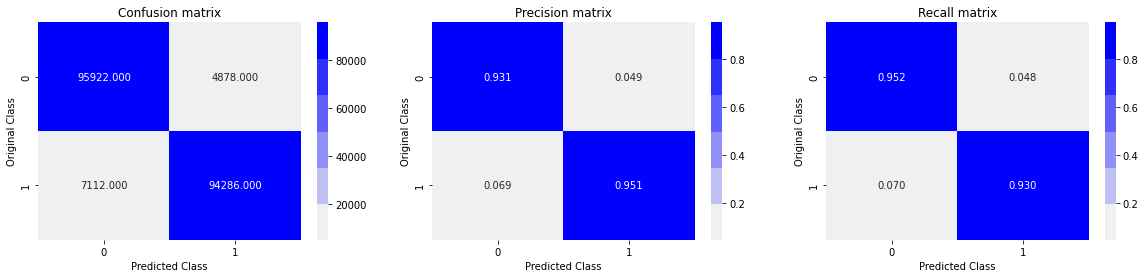

Test confusion_matrix


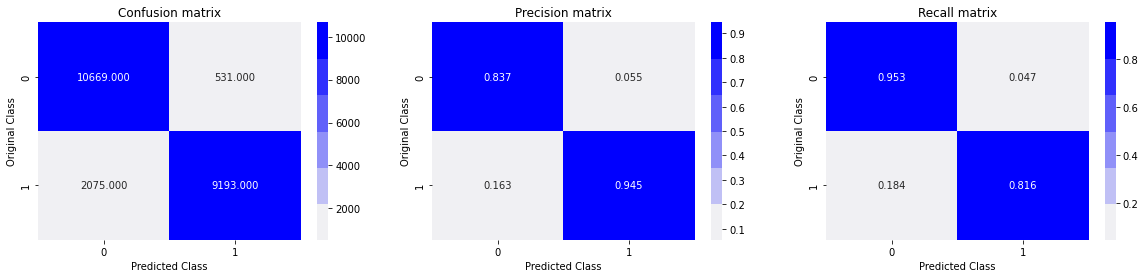

In [47]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

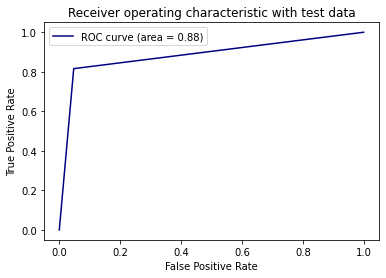

In [48]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

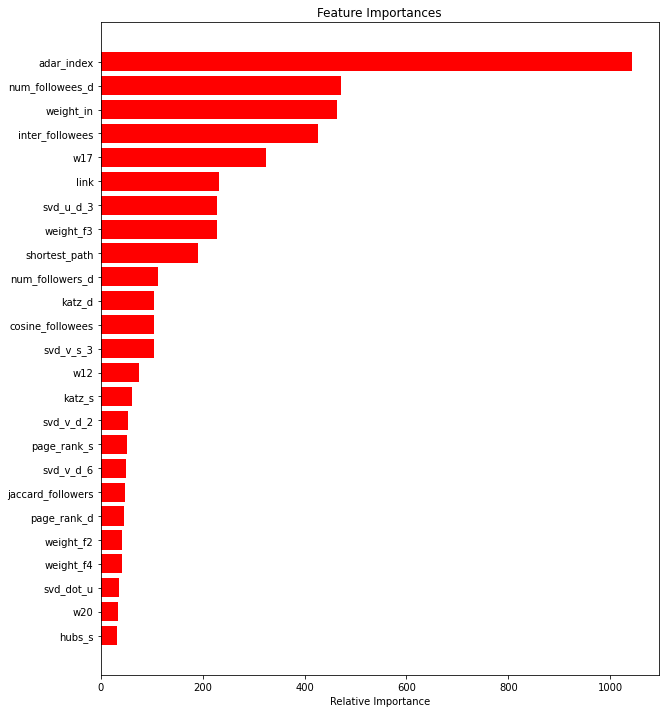

In [49]:
features = ['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'] + ['w' + str(i) for i in range(1, 65)]

importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()